在得到一个BERT预训练模型之后，我们来看看BERT的fine tuning要如何进行

这里我们复习一下前面的知识
* BERT的fine tuning任务其实是比较特殊的，因为BERT在预训练时的任务就比较特殊
* 对于一个机器学习模型来说，所谓的训练任务其实就是训练的loss，比如病人分类任务就对应着分类损失，回归任务就对应着最小二乘损失等等
* 那相较于以往的机器学习模型，BERT的预训练任务（loss）与实际进行fine tuning时候的是不相同的
* BERT在预训练的时候用了mask来进行一系列的处理，从而让BERT能够作为一个预训练的encoder去提取NLP问题中的特征，但是问题是实际应用场景压根不是这个
* 而像CV中，预训练resnet时候任务就是图像分类，而在实际应用也就是fine tuning中任务也是一样的图像分类，甚至就算是目标检测，也很大程度上可以迁移到图像分类问题
* 所以BERT的fine tuning，本质上是要解决前后任务不匹配的问题

那么BERT是如何解决我们上面提到的这些问题的呢？
* 在前面BERT的学习中我们知道，BERT对于每个token都抽取了一个特征向量出来（结合上下文信息的一个特征向量）
* 那么在实际的fine tuning任务中，根据不同的应用场景，使用BERT抽取的不同的特征
* 比如单句子的分类问题，我们就使用BERT抽取的句子开头的token的特征向量，扔到一个fc层里面去做分类预测
* 另一个常见的应用场景是识别一个token是不是一个命名实体，做法就是把所有的非特殊token都扔进去，然后做类别分类
* 如果是给定一段话与一个问题，从这段话里面去找答案
    * 这里就是对于每个token，去预测是不是答案的开头或者结尾
    * 本质上这是一个三分类问题：开头、结尾、啥都不是

* 所以本质上，BERT的fine tuning特殊之处就是，最后我们从头训练的fc层要从BERT中拿哪些token的信息
* 根据不同的问题场景，fc层得到不同的token信息
* 而像resnet预训练，最终的fc层得到的是全部的信息去预测的
* BERT的fine tuning，根据任务的不同，输入的（fc层的输入）表示和使用的BERT_token特征是完全不一样的

接下来我们使用一个SNLI数据集来看一下BERT的预训练任务

SNLI：斯坦福自然语言推断语料库（Stanford Natural Language Inference，SNLI）是由500000多个带标签的英语句子对组成的集合 (Bowman et al., 2015)

In [1]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

#@save
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [2]:
#@save
def read_snli(data_dir, is_train):
    """将SNLI数据集解析为前提、假设和标签"""
    def extract_text(s):
        # 删除我们不会使用的信息
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # 用一个空格替换两个或多个连续的空格
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] \
                in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [3]:
# 这个数据集其实就是很简单的一个问题，给你两句话，然后你去判断一下这两句话的关系是什么
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('前提：', x0)
    print('假设：', x1)
    print('标签：', y)

前提： A person on a horse jumps over a broken down airplane .
假设： A person is training his horse for a competition .
标签： 2
前提： A person on a horse jumps over a broken down airplane .
假设： A person is at a diner , ordering an omelette .
标签： 1
前提： A person on a horse jumps over a broken down airplane .
假设： A person is outdoors , on a horse .
标签： 0


In [4]:
# 可以看出来这还是一个比较平衡的问题
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [6]:
# 接着老办法，构造一个数据集dataset对象
#@save
class SNLIDataset(torch.utils.data.Dataset):
    """用于加载SNLI数据集的自定义数据集"""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        # 注意，因为在NLP领域的模型里面，我们都是要把自然语言换算成0123这些数字的（也就是通过vocab）
        # 所以我们在用BERT做fine tuning的时候，一定要继续使用预训练时候对应的vocab
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + \
                all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [8]:
# 相似的，我们来通过函数调用我们上面写好的dataset类，并且返回一个torch框架可用的dataloader实例（其实也就是一个迭代器啦）
#@save
def load_data_snli(batch_size, num_steps=50):
    """下载SNLI数据集并返回数据迭代器和词表"""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [9]:
# 调用一下读取
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


18678

In [11]:
# 打印一下第一个batch的样子
# batch size是128，pad到50
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


接下来，就是可以正式的开始fine tuning了

其实本质上和前面的resnet啥的fine tuning差别是不大的

In [12]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [14]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [15]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [16]:
# 这里本质上还是构造一个dataset类，只不过是对于BERT来说改成了BERT能用的版本
# 并且这里用了多进程来加速（CV领域数据预处理操作子都是cpp写的，所以不会有这个问题，但是NLP领域很多都是Python写，所以如果纯Python那会发现数据预处理跑不动）

class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [17]:
# 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples
read 9824 examples


In [18]:
# 在这里其实就是一个完整的模型了，可以发现实际上也就是在BERT预训练模型的基础上，加上一个nn.Linear(256, 3)
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [20]:
# 实例化一下
net = BERTClassifier(bert)

loss 0.521, train acc 0.791, test acc 0.782
5996.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


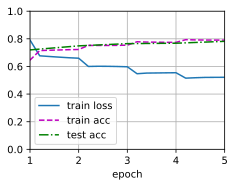

In [21]:
# 这里就是老生常谈的训练操作了
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

# 训练5个epoch其实效果还挺好，有一个差不多0.8的acc

所以总得来说，其实BERT的fine tuning是非常成功的，成功的把CV里面的概念移植到了NLP领域，这也是体现了神经网络这一模型的“语言”特性
* 对于BERT来说，最重要的是将具体问题转化为如何使用BERT提取出来的token特征向量